# Basics of FastPair

1. Setup
2. Properties
3. Appending Values & Vizualization

In [1]:
%config InlineBackend.figure_format = "retina"
%load_ext watermark
%watermark

Last updated: 2024-06-11T22:00:47.741779-04:00

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit



In [2]:
import matplotlib.pyplot as plt
import numpy

import fastpair

%watermark -w
%watermark -iv

Watermark: 2.4.3

matplotlib: 3.9.0
fastpair  : 0.1.1.dev8+g5f8e7a5.d20240611
numpy     : 1.26.4



---------------------------------

## 1. Setup

The following helper function will be used the generate random tuples of points in the example.

* A reproducibile state can be set with the `seed` argument.
* Use the `size` argument to indicate the tuple dimensions.
* Set the `n` argument for the number of desired points
* `low` and `high` control for minimum and maximum values, respectively.
* The [desired distribution](https://numpy.org/doc/stable/reference/random/generator.html#numpy.random.default_rng) is set in `sample`. 

In [3]:
def random_points(
    seed: int = 0,
    size: int | tuple = (2),
    n: int = 1,
    low: int = 0,
    high: int = 20,
    sample: str = "integers",
) -> list[tuple[float]]:
    rng = numpy.random.default_rng(seed)
    return [
        tuple(getattr(rng, sample)(low=low, high=high, size=size)) for i in range(n)
    ]

Generate a single 1D point from seed `0`

In [4]:
random_points(1, 1, 1)

[(9,)]

Generate 3 2D points from seed `1`

In [5]:
random_points(1, (2), 3)

[(9, 10), (15, 19), (0, 2)]

---------------------

## 2. Properties

The simplest way to use a `FastPair` data-structure is to initialize one and then update it with data points (via the `+=` operator), which we will explore later. In this first example, we create a sequence of 3 2D random integers and add them to a `FastPair` object.

In [6]:
points = random_points(1, (2), 3)
points

[(9, 10), (15, 19), (0, 2)]

Create empty data-structure with default values:

* `min_points=10`
* `default=scipy.spatial.distance.euclidean`

In [7]:
fp = fastpair.FastPair()
fp

Add points all at once and build conga line to start:

In [8]:
fp.build(points)

### `FastPair` has several useful properties and methods

1. Checking the size of the data-structure (i.e., how many points are currently stored).
2. Testing for containment of a given point
3. Various methods for computing the closest pair
4. Finding the neighbor of a given point
5. Computing multiple distances at once 
6. ... and *even merging points (clusters)*.

<div class="alert alert-block alert-warning">
<b>Important:</b> merging functionality is not currently implemented
</div>

#### Checking size

How many point are currently stored?

In [9]:
len(fp)

3

#### Testing containment

Is the first element of `points` in the `fp` instance?

In [10]:
points[0] in fp

True

Is a point as `(25, 25)` in the `fp` instance?

In [11]:
(25, 25) in fp

False

#### Computing the closest pair

Simply call the `fp` instance.

In [12]:
fp()

(10.816653826391969, ((9, 10), (15, 19)))

Call the `closest_pair` method of the `fp` instance.

In [13]:
fp.closest_pair()

(10.816653826391969, ((9, 10), (15, 19)))

Call the `closest_pair_brute_force` method.

In [14]:
fp.closest_pair_brute_force()

(10.816653826391969, ((9, 10), (15, 19)))

#### Finding the neighbor of a given point

What's the neighbor of the 2nd element of `points`?

In [15]:
neigh = fp._find_neighbor(points[1])
neigh["neigh"]

(9, 10)

How far away is it?

In [16]:
neigh["dist"]

10.816653826391969

How about about a point outside `points` set?

In [17]:
neigh = fp._find_neighbor((25, 25))
neigh["neigh"]

(15, 19)

In [18]:
neigh["dist"]

11.661903789690601

#### Computing multiple distances at once

How about the distance from a new point at `(-1, -1)` to all points in `fp`?

In [19]:
tuple(fp.sdist((-1, -1)))

((14.866068747318506, (9, 10)),
 (25.612496949731394, (15, 19)),
 (3.1622776601683795, (0, 2)))

--------------

## 3. Appending Values & Vizualization

A key strength of `fastpair` is the ability to incorporate additional points dynamically (or remove them) while the data-structure responds and updates accordingly (see this paper referenced below for details).

* ***David Eppstein*** (2001). *Fast hierarchical clustering and other applications of dynamic closest pairs*. ACM J. Exp. Algorithmics 5 (2000), 1–es. doi: [10.1145/351827.351829](https://doi.org/10.1145/351827.351829)

### Create a fresh `FastPair` instance

4 2D points from a random seed of `101`.

In [20]:
points = random_points(101, (2), 4)
fp = fastpair.FastPair()
fp.build(points)

Query the closest pair.

In [21]:
dist, (a, b) = fp.closest_pair()
dist, (a, b)

(5.0, ((6, 18), (2, 15)))

Vizualize the current set.

* 4 initial points in `"cadetblue"`
* Current closest pair in `"red"`

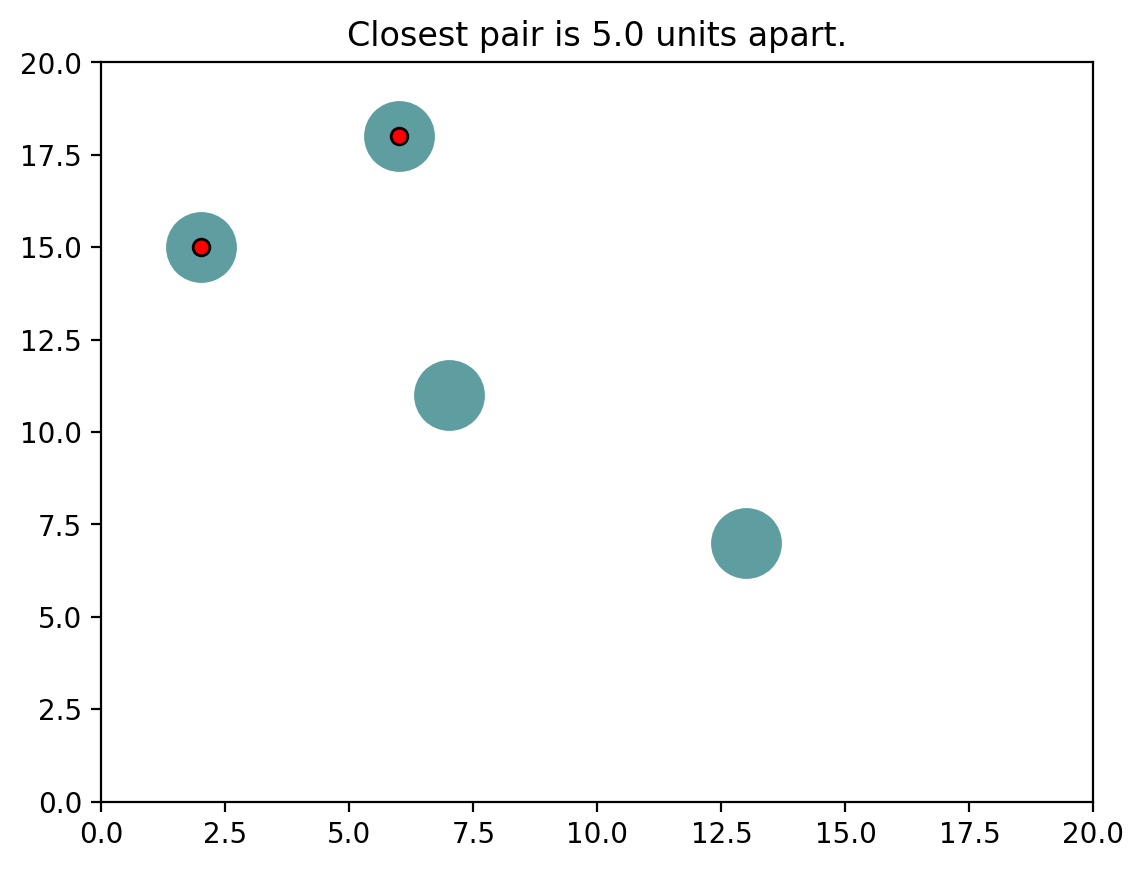

In [22]:
plt.scatter(*zip(*fp.points, strict=True), s=600, color="cadetblue", zorder=1)
plt.scatter(*zip(a, b, strict=True), color="red", ec="k", zorder=2)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.title(f"Closest pair is {dist:.2} units apart.");

Add 4 more 2D points with the `+=` operator and query again.

In [23]:
for p in range(4):
    fp += tuple(*random_points(p, (2), 1))

dist, (a, b) = fp.closest_pair()
dist, (a, b)

(2.23606797749979, ((9, 10), (7, 11)))

The closest pair has been updated!

Vizualize the current set.

* 4 initial points in `"cadetblue"`
* 4 additional points in `"goldenrod"`
* Current closest pair in `"red"`

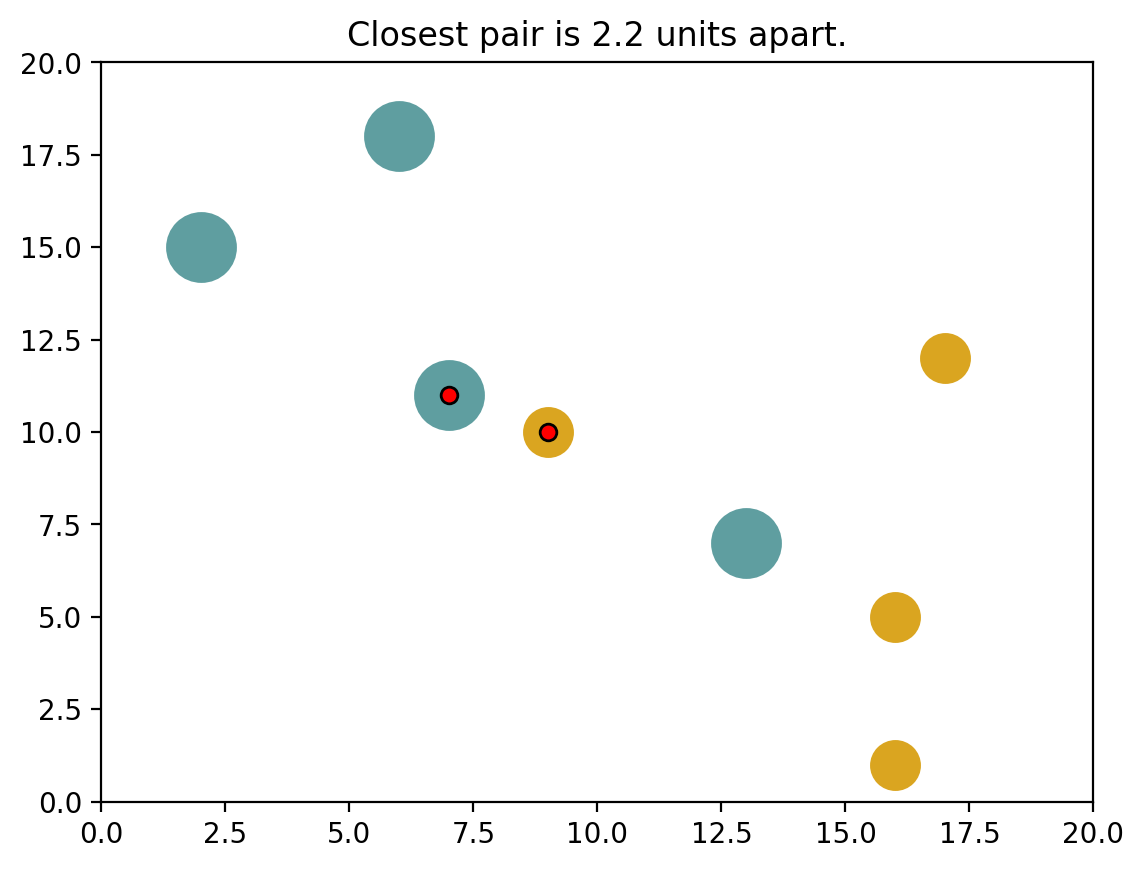

In [24]:
plt.scatter(*zip(*fp.points[:4], strict=True), s=600, color="cadetblue", zorder=1)
plt.scatter(*zip(*fp.points[4:], strict=True), s=300, color="goldenrod", zorder=2)
plt.scatter(*zip(a, b, strict=True), color="red", ec="k", zorder=3)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.title(f"Closest pair is {dist:.2} units apart.");

Add another 4 2D points and query again.

In [25]:
for p in range(4):
    fp += tuple(*random_points(p + 2**p, (2), 1))

dist, (a, b) = fp.closest_pair()
dist, (a, b)

(1.0, ((8, 10), (9, 10)))

The closest pair has once again been updated!

Vizualize the current set.

* 4 initial points in `"cadetblue"`
* First set of 4 additional points in `"goldenrod"`
* Second set of 4 additional points in `"darkolivegreen"`
* Current closest pair in `"red"`

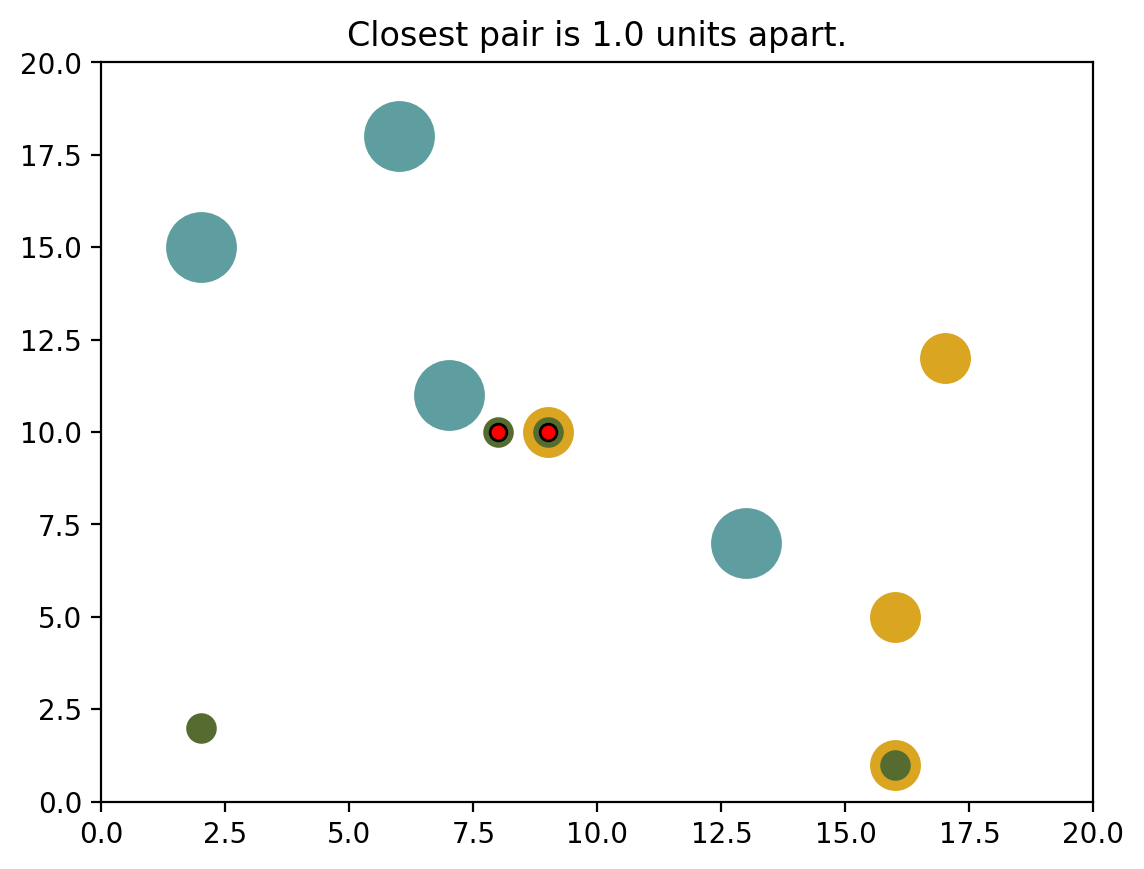

In [26]:
plt.scatter(*zip(*fp.points[:4], strict=True), s=600, color="cadetblue", zorder=1)
plt.scatter(*zip(*fp.points[4:-4], strict=True), s=300, color="goldenrod", zorder=2)
plt.scatter(*zip(*fp.points[-4:], strict=True), s=100, color="darkolivegreen", zorder=3)
plt.scatter(*zip(a, b, strict=True), color="red", ec="k", zorder=4)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.title(f"Closest pair is {dist:.2} units apart.");

------------------------